In [5]:
from dataset import TextDataset
from lstm import LSTMModel
from tokenizer import merge_text_files
from utils import add_special_tokens, collate_fn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm

In [6]:
TOKENIZER_PATH = "bpe_tokenizer.model"
TRAIN_FILE = "data/train.jsonl"
VAL_FILE = "data/test.jsonl"
MAX_SEQ_LEN = 128
BATCH_SIZE = 2048
EMBEDD_DIM = 256
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 100
torch.cuda.get_device_name(0)

'NVIDIA A100 80GB PCIe'

In [7]:
model = LSTMModel(
    vocab_size=10000,
    embedding_dim=EMBEDD_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
)


In [8]:
def train_model(model=None, name=None):
    """
    Training the model.
    """

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    # Load the tokenizer
    tokenizer = spm.SentencePieceProcessor(model_file='bpe_tokenizer.model')
    vocab_size = tokenizer.get_piece_size()

    # Load the dataset
    train_dataset = TextDataset(TRAIN_FILE, tokenizer, MAX_SEQ_LEN)
    val_dataset = TextDataset(VAL_FILE, tokenizer, MAX_SEQ_LEN)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


    model = model.to(device)

    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    # optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=1, factor=0.5, verbose=True)
    criterion = nn.CrossEntropyLoss(ignore_index=3)  # Ignore padding index

    best_val_loss = float('inf')
    no_improve_epochs = 0
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0

        for input_ids, target_ids in train_loader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            optimizer.zero_grad()

            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for input_ids, target_ids in val_loader:
                input_ids, target_ids = input_ids.to(device), target_ids.to(device)


                logits, _ = model(input_ids)
                loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Validation Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), f"best_models/best_model_{name}.pth")
            print("Model saved.")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= 3:
                print("Early stopping triggered.")
                break
    print("Training complete.")
    return train_losses, val_losses


In [9]:
train_losses, val_losses = train_model(model, model._get_name())

Using device: cuda


/home/madrez/.conda/envs/fai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 7.8283
Epoch 1/100, Validation Loss: 6.7957
Model saved.
Epoch 2/100, Train Loss: 6.7415
Epoch 2/100, Validation Loss: 6.7022
Model saved.
Epoch 3/100, Train Loss: 6.6908
Epoch 3/100, Validation Loss: 6.6827
Model saved.
Epoch 4/100, Train Loss: 6.6792
Epoch 4/100, Validation Loss: 6.6749
Model saved.
Epoch 5/100, Train Loss: 6.6714
Epoch 5/100, Validation Loss: 6.6647
Model saved.
Epoch 6/100, Train Loss: 6.6576
Epoch 6/100, Validation Loss: 6.6443
Model saved.
Epoch 7/100, Train Loss: 6.6255
Epoch 7/100, Validation Loss: 6.5974
Model saved.
Epoch 8/100, Train Loss: 6.5650
Epoch 8/100, Validation Loss: 6.5231
Model saved.
Epoch 9/100, Train Loss: 6.4891
Epoch 9/100, Validation Loss: 6.4492
Model saved.
Epoch 10/100, Train Loss: 6.4191
Epoch 10/100, Validation Loss: 6.3837
Model saved.
Epoch 11/100, Train Loss: 6.3557
Epoch 11/100, Validation Loss: 6.3224
Model saved.
Epoch 12/100, Train Loss: 6.2917
Epoch 12/100, Validation Loss: 6.2550
Model saved.
Epoch 13/1

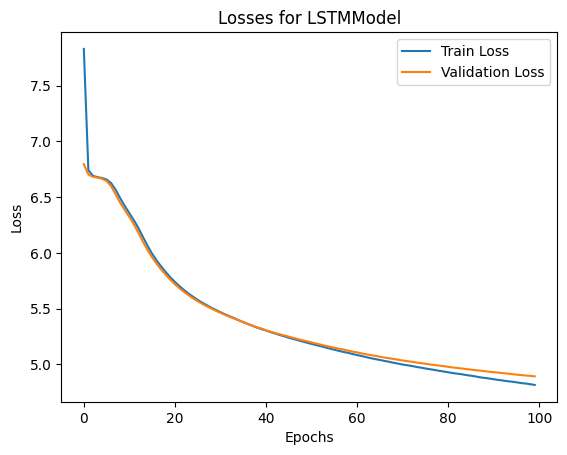

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Losses for {model._get_name()}')
plt.legend()
plt.savefig(f"losses_{model._get_name()}.png")
plt.show()

In [11]:
# save losses
import json
with open(f"best_models/losses_{model._get_name()}.json", "w") as f:
    json.dump({"train": train_losses, "val": val_losses}, f)